In [79]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # to separate pages based on language (regular expression)
import matplotlib.pyplot as plt # to visualize data

from datetime import datetime

import itertools
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from datetime import timedelta
from time import time
from statsmodels.tsa.stattools import acf, pacf

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [80]:
#Importing data
train_df = pd.read_csv('/Users/ta.duong/data/AggregatedData.csv')
train_df

,ATM Name,Transaction Date,No Of Withdrawals,No Of XYZ Card Withdrawals,No Of Other Card Withdrawals,Total amount Withdrawn,Amount withdrawn XYZ Card,Amount withdrawn Other Card,Weekday,Festival Religion,Working Day,Holiday Sequence
0,Big Street ATM,1/1/2011,50,20,30,123800,41700,82100,Saturday,H,H,WHH
1,Mount Road ATM,1/1/2011,253,67,186,767900,270900,497000,Saturday,C,H,WHH
2,Airport ATM,1/1/2011,98,56,42,503400,347700,155700,Saturday,C,H,WHH
3,KK Nagar ATM,1/1/2011,265,159,106,945300,532600,412700,Saturday,C,H,WHH
4,Christ College ATM,1/1/2011,74,25,49,287700,148200,139500,Saturday,C,H,WHH
...,...,...,...,...,...,...,...,...,...,...,...,...
11584,Big Street ATM,29-09-2017,137,34,103,468800,146200,322600,FRIDAY,H,H,WHH
11585,Mount Road ATM,29-09-2017,79,27,52,305100,172500,132600,FRIDAY,H,H,WHH
11586,Airport ATM,29-09-2017,117,77,40,709900,576800,133100,FRIDAY,H,H,WHH
11587,KK Nagar ATM,29-09-2017,76,48,28,408700,279900,128800,FRIDAY,H,H,WHH


In [81]:
#Cleaning, transforming data
train_df['Transaction Date'] = train_df['Transaction Date'].str.replace('/', '-')
train_df['Weekday'] = train_df['Weekday'].str.lower()


train_df['Transaction Date'] = pd.to_datetime(train_df['Transaction Date'], format='%d-%m-%Y')

#Picking KK Nagar as the ATM of choice
ATM_Name = train_df.groupby('ATM Name')
ap_atm_df = ATM_Name.get_group('KK Nagar ATM')

df = ap_atm_df[['Transaction Date', 'Total amount Withdrawn']]
df = df.set_index('Transaction Date')
df

,Total amount Withdrawn
Transaction Date,
2011-01-01,945300
2011-01-02,809400
2011-01-03,1333100
2011-01-04,999400
2011-01-05,959200
...,...
2017-09-25,1175200
2017-09-26,738200
2017-09-27,997800


In [82]:
#Using AVR monthly data
df_ms = df.resample('MS').mean()
df_ms

,Total amount Withdrawn
Transaction Date,
2011-01-01,746361.290323
2011-02-01,721746.428571
2011-03-01,726435.483871
2011-04-01,648363.333333
2011-05-01,701396.774194
...,...
2017-05-01,578493.548387
2017-06-01,664703.333333
2017-07-01,400052.000000


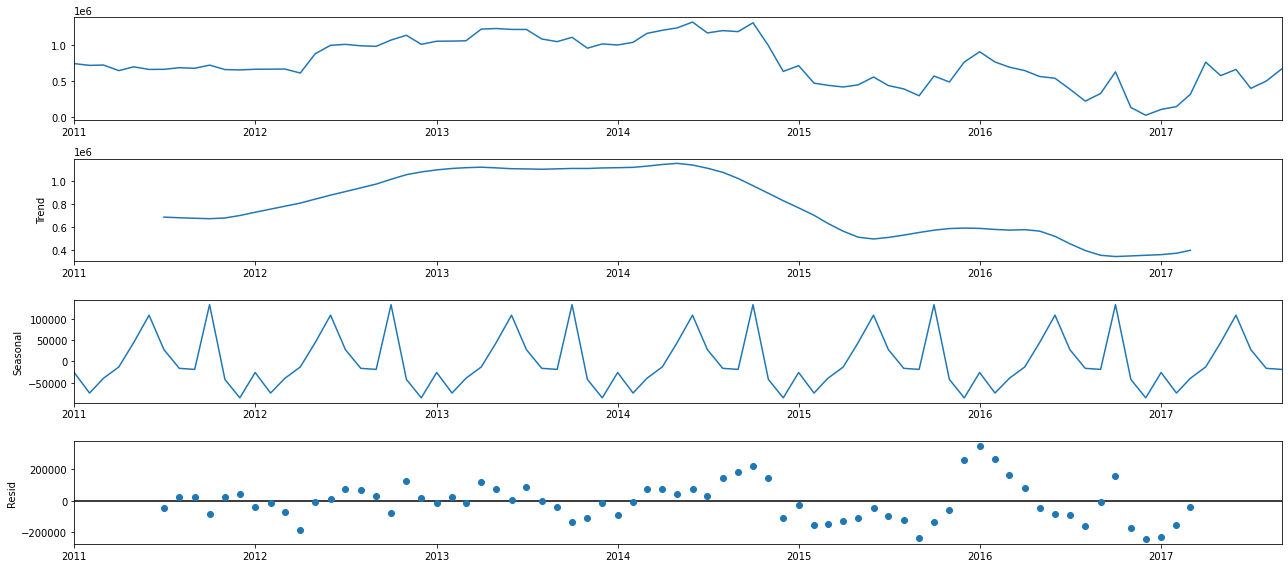

In [83]:
#Plot model
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_ms, model='additive')
fig = decomposition.plot()
plt.show()

Results of Dickey-Fuller Test:
p-value = 0.2792. The series is likely non-stationary.
Test Statistic                 -2.016969
p-value                         0.279183
#Lags Used                      0.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


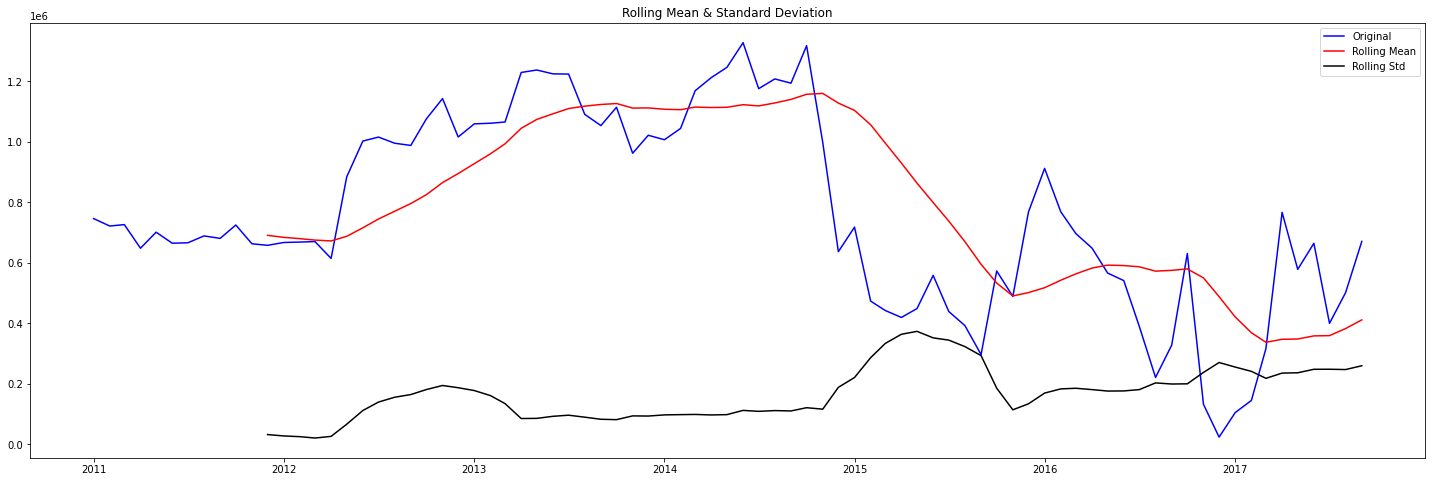

In [84]:
#Checking stationary

#define function for ADF test
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(25, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    pvalue = dftest[1]
    #Add Critical Values
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    print(dfoutput)
    
test_stationarity(df_ms['Total amount Withdrawn'])

In [85]:
#Making the model stationary
first_diff = df_ms.diff()[1:]

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -9.414795e+00
p-value                        5.707464e-16
#Lags Used                     0.000000e+00
Number of Observations Used    7.900000e+01
Critical Value (1%)           -3.515977e+00
Critical Value (5%)           -2.898886e+00
Critical Value (10%)          -2.586694e+00
dtype: float64


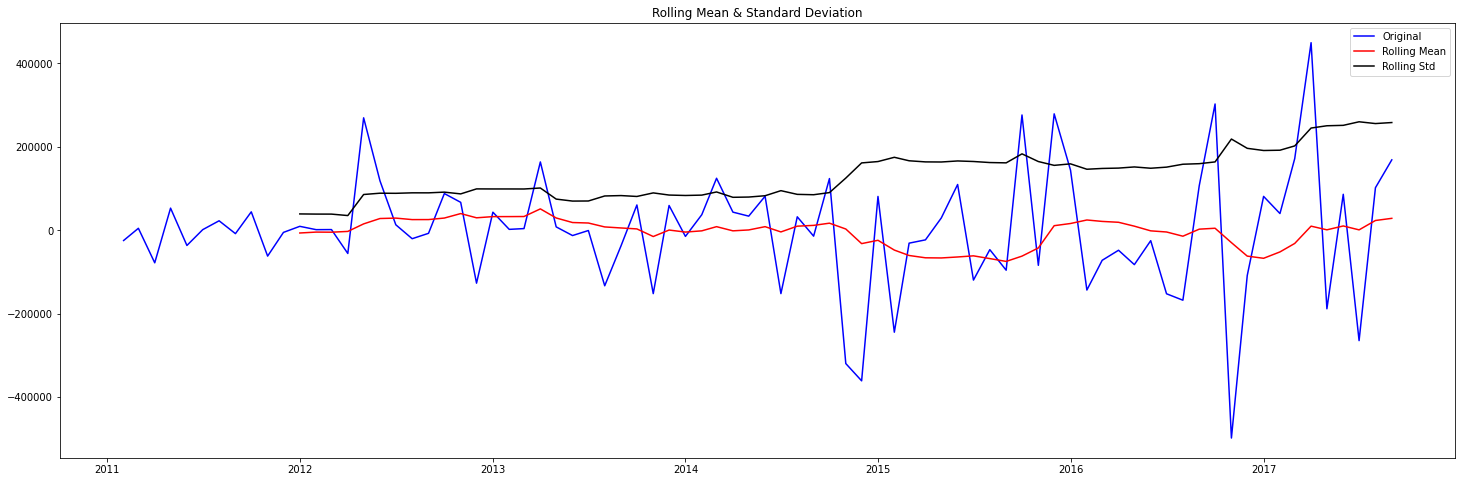

In [86]:
#Retesting
test_stationarity(first_diff['Total amount Withdrawn'])

In [256]:
#Testing with auto arima
auto_arima(df_ms['Total amount Withdrawn'], seasonal=True, m=12, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2130.702, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2133.420, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2133.747, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2128.712, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2131.566, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2131.893, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2130.042, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2132.233, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2132.270, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2133.566, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.806 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   81
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1063.356
Date:                Tue, 04 May 2021   AIC                           2128.712
Time:                        16:35:21   BIC                           2131.094
Sample:                             0   HQIC                          2129.667
                                 - 81                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.029e+10    2.2e+09      9.211      0.000     1.6e+10    2.46e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                15.91
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               6.37   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [141]:
mod = sm.tsa.statespace.SARIMAX(df_ms,
                                trend='n',
                                order=(0, 1, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False
                                )
results = mod.fit()
print(results.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Total amount Withdrawn   No. Observations:                   81
Model:                   SARIMAX(0, 1, 0)   Log Likelihood               -1050.555
Date:                    Tue, 04 May 2021   AIC                           2103.110
Time:                            15:44:35   BIC                           2105.480
Sample:                        01-01-2011   HQIC                          2104.060
                             - 09-01-2017                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.029e+10   2.21e+09      9.199      0.000     1.6e+10    2.46e+10
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):                14.93
Prob(Q):       

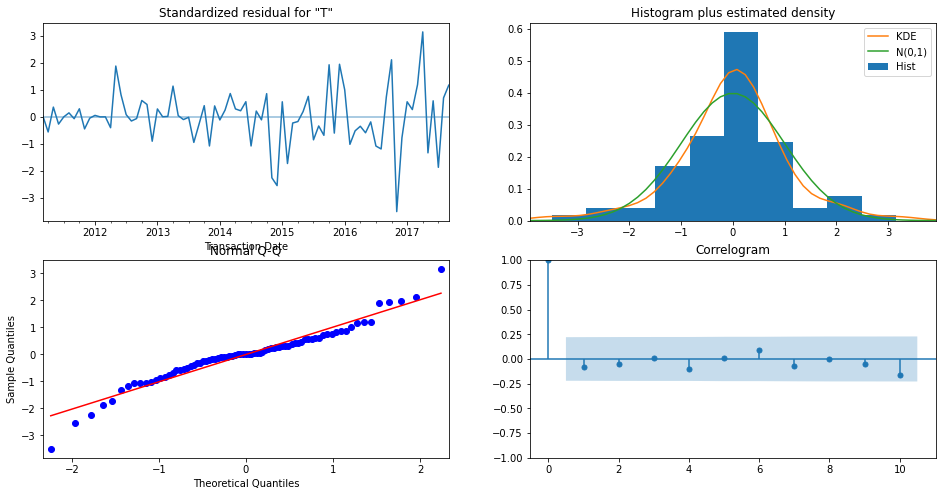

In [142]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

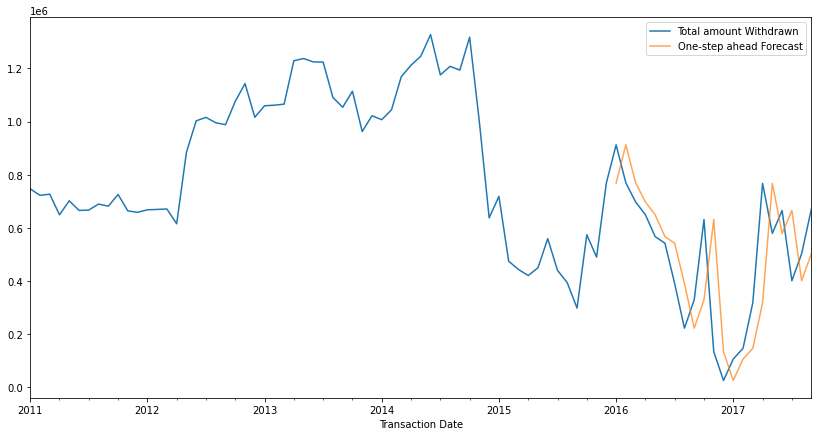

In [143]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_ms['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

plt.legend()
plt.show()


In [146]:
#Using ACF&PACF
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

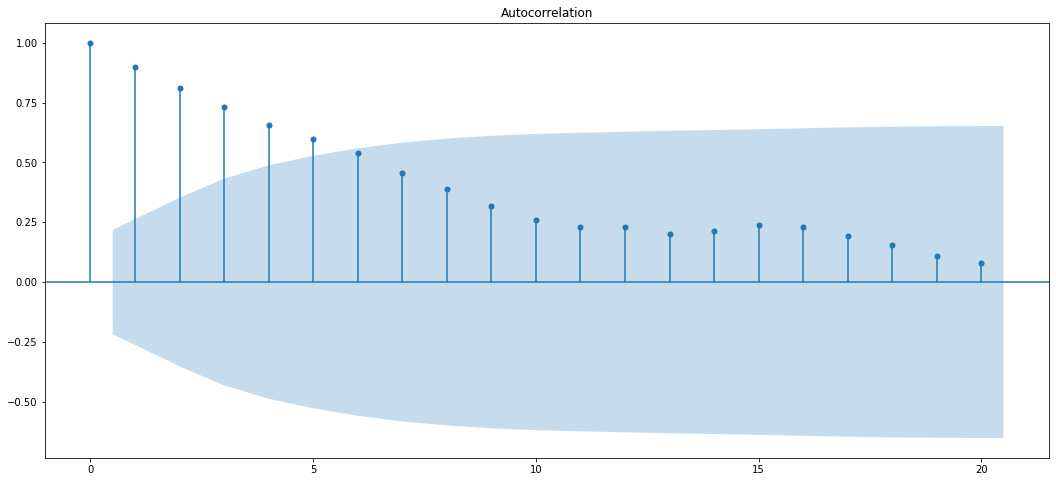

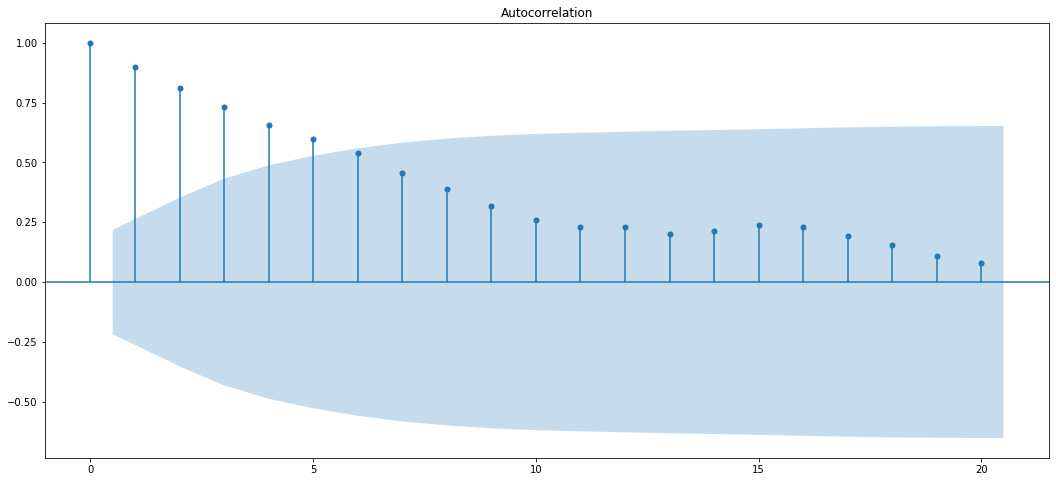

In [147]:
plot_acf(df_ms)

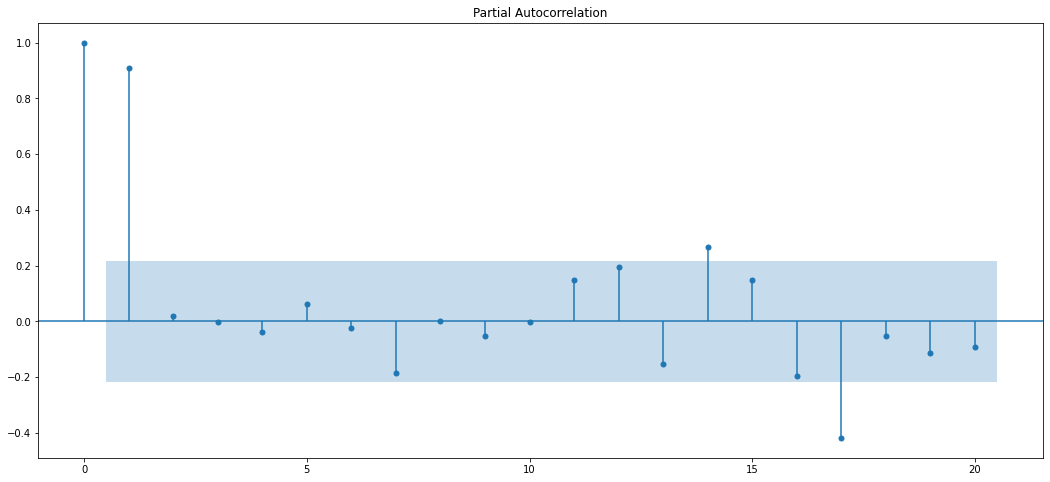

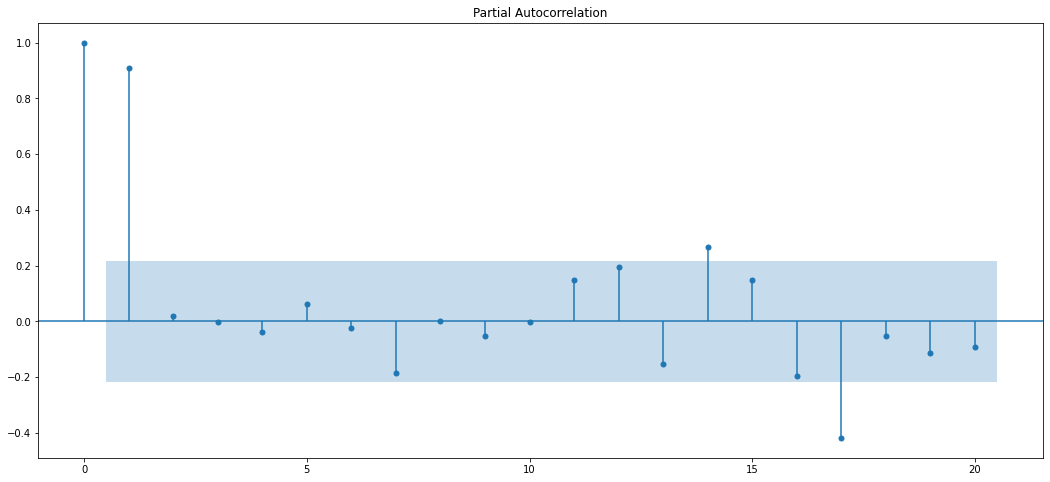

In [148]:
# Q - 5, p - 1 , d - 0-2
plot_pacf(df_ms)

In [228]:
mod = sm.tsa.statespace.SARIMAX(df_ms,
                                trend='n',
                                order=(1, 0, 5),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False
                                )
results = mod.fit()
print(results.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Total amount Withdrawn   No. Observations:                   81
Model:                   SARIMAX(1, 0, 5)   Log Likelihood               -1077.999
Date:                    Tue, 04 May 2021   AIC                           2169.998
Time:                            16:02:00   BIC                           2186.759
Sample:                        01-01-2011   HQIC                          2176.723
                             - 09-01-2017                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9889      0.021     48.149      0.000       0.949       1.029
ma.L1         -0.0818      0.121     -0.676      0.499      -0.319       0.156
ma.L2         -0.041

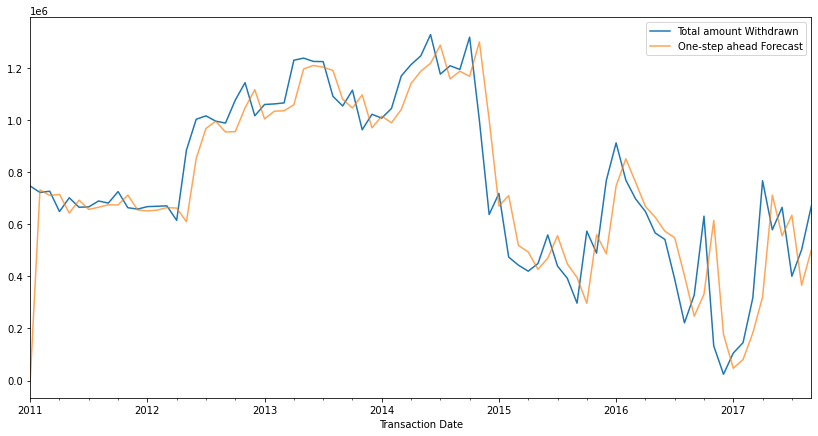

In [231]:
pred = results.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_ms['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

plt.legend()
plt.show()
